In [ ]:
!pip -q install opencv-python-headless pillow


In [38]:
from IPython.display import Javascript, display
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='sketch_capture.jpg', quality=0.95):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture sketch photo';
      capture.style.padding = '10px 14px';
      capture.style.margin = '6px 0';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      video.style.width = '480px';
      video.style.border = '1px solid #ddd';
      video.style.borderRadius = '10px';
      const stream = await navigator.mediaDevices.getUserMedia({video: true, audio: false});
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Wait for user click
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getTracks().forEach(t => t.stop());
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
  ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  print("Saved:", filename)
  return filename

take_photo()


<IPython.core.display.Javascript object>

Saved: sketch_capture.jpg


'sketch_capture.jpg'

In [40]:
import cv2
import numpy as np
from PIL import Image

img = cv2.imread("sketch_capture.jpg")
if img is None:
  raise RuntimeError("Could not read sketch_capture.jpg")

# 1) grayscale + blur
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray_blur = cv2.GaussianBlur(gray, (5, 5), 0)

# 2) ink mask (tune threshold)
# lower -> captures more (including noise), higher -> cleaner but may miss light strokes
_, mask = cv2.threshold(gray_blur, 170, 255, cv2.THRESH_BINARY_INV)

# 3) clean noise
kernel = np.ones((3,3), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)

# 4) keep only largest connected component (removes random dots)
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
if num_labels > 1:
  # skip background label 0
  largest = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
  mask = np.where(labels == largest, 255, 0).astype(np.uint8)

# 5) crop tightly around the mask
ys, xs = np.where(mask > 0)
if len(xs) == 0 or len(ys) == 0:
  raise RuntimeError("No ink detected. Try lowering threshold (e.g., 150).")

x1, x2 = xs.min(), xs.max()
y1, y2 = ys.min(), ys.max()

pad = 20
x1 = max(0, x1 - pad); y1 = max(0, y1 - pad)
x2 = min(mask.shape[1]-1, x2 + pad); y2 = min(mask.shape[0]-1, y2 + pad)

crop_rgb = cv2.cvtColor(img[y1:y2+1, x1:x2+1], cv2.COLOR_BGR2RGB)
crop_mask = mask[y1:y2+1, x1:x2+1]

# 6) IMPORTANT: remove paper colors from RGB by multiplying with alpha
alpha = (crop_mask.astype(np.float32) / 255.0)[..., None]
rgb_clean = (crop_rgb.astype(np.float32) * alpha).astype(np.uint8)

rgba = np.dstack([rgb_clean, crop_mask])
Image.fromarray(rgba).save("sketch_transparent.png")

print("Saved: sketch_transparent.png")


Saved: sketch_transparent.png


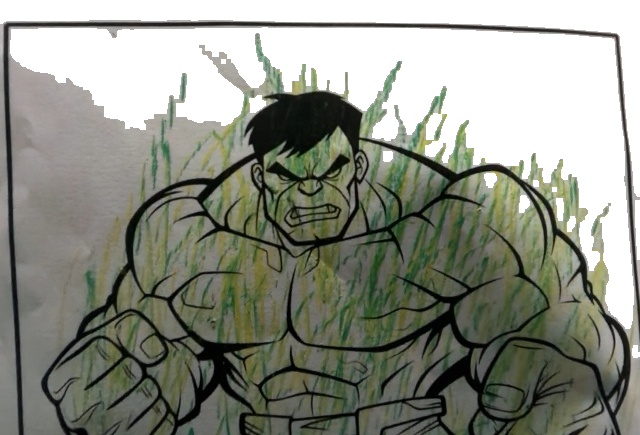

In [41]:
from IPython.display import Image as IPImage, display
display(IPImage("sketch_transparent.png"))



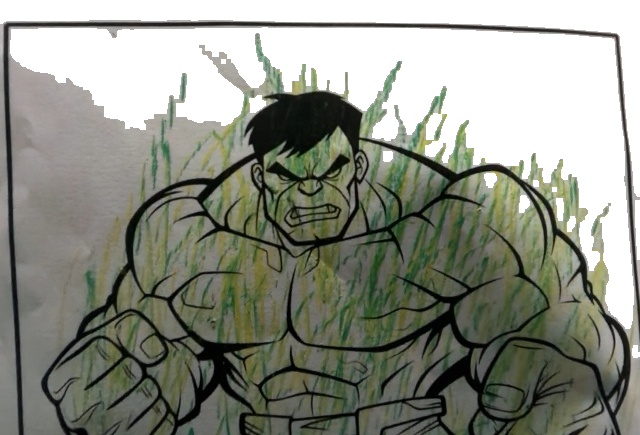

In [46]:
from IPython.display import HTML, display

display(HTML(f"""
<div style="width:860px; max-width:100%;">
  <h3>3D Aquarium + Predefined Sea Animals (Three.js)</h3>
  <div id="aquarium" style="width:860px; height:520px; border:1px solid #ddd; border-radius:14px; overflow:hidden;"></div>
  <div style="font-family:system-ui; color:#444; margin-top:6px;">
    Tip: Re-run this cell anytime to randomize fish/jelly paths.
  </div>
</div>

<script src="https://unpkg.com/three@0.160.0/build/three.min.js"></script>
<script>
(() => {{
  const container = document.getElementById("aquarium");

  // ---------- Renderer ----------
  const renderer = new THREE.WebGLRenderer({{ antialias: true, alpha: true }});
  renderer.setSize(container.clientWidth, container.clientHeight);
  renderer.setPixelRatio(window.devicePixelRatio);
  renderer.outputColorSpace = THREE.SRGBColorSpace;
  renderer.toneMapping = THREE.ACESFilmicToneMapping;
  renderer.toneMappingExposure = 1.05;
  container.appendChild(renderer.domElement);

  // ---------- Scene / Camera ----------
  const scene = new THREE.Scene();
  scene.fog = new THREE.FogExp2(0x07243d, 0.06);

  const camera = new THREE.PerspectiveCamera(55, container.clientWidth / container.clientHeight, 0.1, 100);
  camera.position.set(0, 1.25, 6.4);

  // Background gradient
  const bgCanvas = document.createElement("canvas");
  bgCanvas.width = 1; bgCanvas.height = 256;
  const bgCtx = bgCanvas.getContext("2d");
  const grad = bgCtx.createLinearGradient(0, 0, 0, 256);
  grad.addColorStop(0.00, "#0a3a63");
  grad.addColorStop(0.45, "#062a4a");
  grad.addColorStop(1.00, "#041c33");
  bgCtx.fillStyle = grad;
  bgCtx.fillRect(0, 0, 1, 256);
  const bgTex = new THREE.CanvasTexture(bgCanvas);
  bgTex.colorSpace = THREE.SRGBColorSpace;
  scene.background = bgTex;

  // ---------- Lights ----------
  scene.add(new THREE.AmbientLight(0xffffff, 0.35));

  const key = new THREE.DirectionalLight(0xbfe6ff, 1.25);
  key.position.set(3, 7, 4);
  scene.add(key);

  const fill = new THREE.DirectionalLight(0x7fd0ff, 0.55);
  fill.position.set(-5, 2.5, 2);
  scene.add(fill);

  const rim = new THREE.DirectionalLight(0x6aa6ff, 0.35);
  rim.position.set(0, 2, -6);
  scene.add(rim);

  // Aquarium "glass" box
  const box = new THREE.Mesh(
    new THREE.BoxGeometry(20, 10, 20),
    new THREE.MeshPhysicalMaterial({{
      color: 0x0a3356, transparent: true, opacity: 0.18,
      roughness: 0.15, metalness: 0.0, side: THREE.BackSide
    }})
  );
  scene.add(box);

  // Floor (sand-ish)
  const sandCanvas = document.createElement("canvas");
  sandCanvas.width = 256; sandCanvas.height = 256;
  const sctx = sandCanvas.getContext("2d");
  const imgData = sctx.createImageData(256, 256);
  for (let i = 0; i < imgData.data.length; i += 4) {{
    const v = 200 + Math.random() * 35;
    imgData.data[i+0] = v;
    imgData.data[i+1] = v * 0.95;
    imgData.data[i+2] = v * 0.75;
    imgData.data[i+3] = 255;
  }}
  sctx.putImageData(imgData, 0, 0);
  const sandTex = new THREE.CanvasTexture(sandCanvas);
  sandTex.wrapS = sandTex.wrapT = THREE.RepeatWrapping;
  sandTex.repeat.set(8, 8);
  sandTex.colorSpace = THREE.SRGBColorSpace;

  const floor = new THREE.Mesh(
    new THREE.PlaneGeometry(30, 30),
    new THREE.MeshStandardMaterial({{
      map: sandTex, color: 0xffffff, roughness: 1.0, metalness: 0.0
    }})
  );
  floor.rotation.x = -Math.PI / 2;
  floor.position.y = -1.35;
  scene.add(floor);

  // ---------- Helper: generate sprite textures ----------
  function makeFishTexture() {{
    const c = document.createElement("canvas");
    c.width = 128; c.height = 64;
    const ctx = c.getContext("2d");

    // body gradient
    const g = ctx.createLinearGradient(20, 0, 110, 0);
    g.addColorStop(0, "rgba(255,255,255,0.95)");
    g.addColorStop(0.4, "rgba(170,220,255,0.95)");
    g.addColorStop(1, "rgba(90,160,255,0.95)");

    ctx.fillStyle = g;
    ctx.beginPath();
    ctx.ellipse(62, 32, 34, 18, 0, 0, Math.PI*2);
    ctx.fill();

    // tail
    ctx.fillStyle = "rgba(110,180,255,0.9)";
    ctx.beginPath();
    ctx.moveTo(28, 32);
    ctx.lineTo(8, 18);
    ctx.lineTo(8, 46);
    ctx.closePath();
    ctx.fill();

    // fin
    ctx.fillStyle = "rgba(140,210,255,0.7)";
    ctx.beginPath();
    ctx.moveTo(60, 32);
    ctx.quadraticCurveTo(52, 10, 74, 18);
    ctx.quadraticCurveTo(70, 28, 60, 32);
    ctx.closePath();
    ctx.fill();

    // eye
    ctx.fillStyle = "rgba(0,0,0,0.8)";
    ctx.beginPath();
    ctx.arc(82, 28, 3.2, 0, Math.PI*2);
    ctx.fill();

    // soft outline
    ctx.strokeStyle = "rgba(255,255,255,0.25)";
    ctx.lineWidth = 2;
    ctx.beginPath();
    ctx.ellipse(62, 32, 34, 18, 0, 0, Math.PI*2);
    ctx.stroke();

    const tex = new THREE.CanvasTexture(c);
    tex.colorSpace = THREE.SRGBColorSpace;
    return tex;
  }}

  function makeJellyTexture() {{
    const c = document.createElement("canvas");
    c.width = 128; c.height = 128;
    const ctx = c.getContext("2d");

    // dome
    const g = ctx.createRadialGradient(64, 52, 6, 64, 64, 56);
    g.addColorStop(0, "rgba(220,255,255,0.85)");
    g.addColorStop(1, "rgba(120,200,255,0.05)");
    ctx.fillStyle = g;
    ctx.beginPath();
    ctx.ellipse(64, 58, 38, 32, 0, Math.PI, 0, true);
    ctx.closePath();
    ctx.fill();

    // rim
    ctx.strokeStyle = "rgba(200,255,255,0.25)";
    ctx.lineWidth = 2;
    ctx.beginPath();
    ctx.ellipse(64, 58, 38, 32, 0, Math.PI, 0, true);
    ctx.stroke();

    // tentacles
    ctx.strokeStyle = "rgba(180,240,255,0.25)";
    ctx.lineWidth = 2;
    for (let i = -3; i <= 3; i++) {{
      ctx.beginPath();
      ctx.moveTo(64 + i*8, 64);
      ctx.bezierCurveTo(60 + i*8, 80, 70 + i*8, 96, 64 + i*8, 112);
      ctx.stroke();
    }}

    const tex = new THREE.CanvasTexture(c);
    tex.colorSpace = THREE.SRGBColorSpace;
    return tex;
  }}

  // ---------- Bubbles ----------
  const bubbleCount = 700;
  const bubbleGeo = new THREE.BufferGeometry();
  const bpos = new Float32Array(bubbleCount * 3);
  const bvel = new Float32Array(bubbleCount);
  for (let i = 0; i < bubbleCount; i++) {{
    bpos[i*3+0] = (Math.random() - 0.5) * 18;
    bpos[i*3+1] = (Math.random() - 0.5) * 8;
    bpos[i*3+2] = (Math.random() - 0.5) * 18;
    bvel[i] = 0.004 + Math.random() * 0.012;
  }}
  bubbleGeo.setAttribute("position", new THREE.BufferAttribute(bpos, 3));
  const bubbles = new THREE.Points(
    bubbleGeo,
    new THREE.PointsMaterial({{
      color: 0xcaf0ff, size: 0.035, transparent: true, opacity: 0.65, depthWrite: false
    }})
  );
  scene.add(bubbles);

  // ---------- Tiny plankton (sparkly drifting points) ----------
  const plankCount = 900;
  const plankGeo = new THREE.BufferGeometry();
  const ppos = new Float32Array(plankCount * 3);
  for (let i = 0; i < plankCount; i++) {{
    ppos[i*3+0] = (Math.random() - 0.5) * 18;
    ppos[i*3+1] = (Math.random() - 0.5) * 8;
    ppos[i*3+2] = (Math.random() - 0.5) * 18;
  }}
  plankGeo.setAttribute("position", new THREE.BufferAttribute(ppos, 3));
  const plank = new THREE.Points(
    plankGeo,
    new THREE.PointsMaterial({{
      color: 0xe9fbff, size: 0.012, transparent: true, opacity: 0.35, depthWrite: false
    }})
  );
  scene.add(plank);

  // ---------- Predefined sea animals (sprites) ----------
  const fishTex = makeFishTexture();
  const jellyTex = makeJellyTexture();

  const animals = [];
  const ANIM_FISH = 14;      // <--- change count
  const ANIM_JELLY = 6;      // <--- change count

  function spawnAnimal(type) {{
    const tex = (type === "fish") ? fishTex : jellyTex;
    const aspect = (type === "fish") ? (128/64) : 1.0;

    const size = (type === "fish")
      ? (0.45 + Math.random() * 0.55)
      : (0.55 + Math.random() * 0.75);

    const mat = new THREE.SpriteMaterial({{
      map: tex, transparent: true, depthWrite: false, opacity: (type === "fish" ? 0.95 : 0.85)
    }});
    const spr = new THREE.Sprite(mat);

    spr.scale.set(size * aspect, size, 1);

    // random start position and depth
    spr.position.set(
      (Math.random() - 0.5) * 12,
      -0.6 + Math.random() * 3.6,
      -5 + Math.random() * 6   // deeper is more negative
    );

    const speed = (type === "fish")
      ? (0.010 + Math.random() * 0.018)
      : (0.004 + Math.random() * 0.008);

    const dir = (Math.random() < 0.5) ? 1 : -1;

    animals.push({{
      type,
      spr,
      speed,
      dir,
      phase: Math.random() * Math.PI * 2,
      wobble: 0.15 + Math.random() * 0.25,
      lane: spr.position.y
    }});

    scene.add(spr);
  }}

  for (let i=0; i<ANIM_FISH; i++) spawnAnimal("fish");
  for (let i=0; i<ANIM_JELLY; i++) spawnAnimal("jelly");

  // ---------- Your sketch as a featured "creature" ----------
  const userTex = new THREE.TextureLoader().load("{png_data_url}");
  userTex.colorSpace = THREE.SRGBColorSpace;

  const userMat = new THREE.MeshBasicMaterial({{ map: userTex, transparent: true, depthWrite: false }});
  const userGeo = new THREE.PlaneGeometry(2.0, 1.3);
  const user = new THREE.Mesh(userGeo, userMat);

  user.position.set(-6.2, 0.0, 0.4);
  scene.add(user);

  // soft glow behind user
  const glow = new THREE.Mesh(
    new THREE.CircleGeometry(1.05, 32),
    new THREE.MeshBasicMaterial({{
      color: 0x88d8ff, transparent: true, opacity: 0.09, depthWrite: false
    }})
  );
  glow.position.copy(user.position);
  glow.position.z -= 0.08;
  scene.add(glow);

  // ---------- Animation ----------
  let t = 0;

  function animate() {{
    requestAnimationFrame(animate);
    t += 0.01;

    // Bubbles
    const bp = bubbleGeo.attributes.position;
    for (let i = 0; i < bubbleCount; i++) {{
      bp.array[i*3+1] += bvel[i];
      bp.array[i*3+0] += Math.sin(t*0.7 + i) * 0.0005;
      bp.array[i*3+2] += Math.cos(t*0.6 + i) * 0.0005;
      if (bp.array[i*3+1] > 4.3) bp.array[i*3+1] = -4.3;
    }}
    bp.needsUpdate = true;

    // Plankton drift
    const pp = plankGeo.attributes.position;
    for (let i = 0; i < plankCount; i++) {{
      pp.array[i*3+0] += Math.sin(t*0.2 + i) * 0.00015;
      pp.array[i*3+1] += Math.cos(t*0.25 + i) * 0.00008;
      if (pp.array[i*3+0] > 9) pp.array[i*3+0] = -9;
      if (pp.array[i*3+0] < -9) pp.array[i*3+0] = 9;
    }}
    pp.needsUpdate = true;

    // Predefined animals swim
    for (const a of animals) {{
      const s = a.spr;

      if (a.type === "fish") {{
        s.position.x += a.speed * a.dir;
        s.position.y = a.lane + Math.sin(t*1.2 + a.phase) * a.wobble;
        s.position.z += Math.sin(t*0.7 + a.phase) * 0.002;

        // wrap and flip
        if (s.position.x > 7.2) {{ a.dir = -1; }}
        if (s.position.x < -7.2) {{ a.dir = 1; }}

        // face direction (sprite flip)
        s.scale.x = Math.abs(s.scale.x) * a.dir;

      }} else {{
        // jellyfish: float upward slowly + drift
        s.position.y += a.speed;
        s.position.x += Math.sin(t*0.6 + a.phase) * 0.004;
        s.material.opacity = 0.75 + 0.15 * Math.sin(t*1.6 + a.phase);

        if (s.position.y > 3.6) {{
          s.position.y = -0.9;
          s.position.x = (Math.random() - 0.5) * 12;
          s.position.z = -5 + Math.random() * 6;
        }}
      }}
    }}

    // User sketch swim (featured)
    user.position.x += 0.02;
    user.position.y = Math.sin(t) * 0.45;
    user.position.z = 0.4 + Math.sin(t*0.6) * 0.4;
    user.rotation.y = Math.sin(t) * 0.25;
    if (user.position.x > 6.8) user.position.x = -6.8;

    // billboard user mesh
    user.lookAt(camera.position);

    glow.position.copy(user.position);
    glow.position.z -= 0.08;

    renderer.render(scene, camera);
  }}
  animate();

  // Resize
  new ResizeObserver(() => {{
    const w = container.clientWidth, h = container.clientHeight;
    renderer.setSize(w, h);
    camera.aspect = w / h;
    camera.updateProjectionMatrix();
  }}).observe(container);

}})();
</script>
"""))
